Import everything we will use in this work for data preparation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load and preprocess the data

In [2]:

# Load the CSV file
data = pd.read_csv('data/restaurant_data.csv')

# Display the first five rows
print(data.head())

           Name  Location   Cuisine  Rating  Seating Capacity  \
0  Restaurant 0     Rural  Japanese     4.0                38   
1  Restaurant 1  Downtown   Mexican     3.2                76   
2  Restaurant 2     Rural   Italian     4.7                48   
3  Restaurant 3     Rural   Italian     4.4                34   
4  Restaurant 4  Downtown  Japanese     4.9                88   

   Average Meal Price  Marketing Budget  Social Media Followers  \
0               73.98              2224                   23406   
1               28.11              4416                   42741   
2               48.29              2796                   37285   
3               51.55              1167                   15214   
4               75.98              3639                   40171   

   Chef Experience Years  Number of Reviews  Avg Review Length  \
0                     13                185         161.924906   
1                      8                533         148.759717   
2       

Clearly we don't need the "Name" column.
First two columns are discrete classes, let's enumerate them. Every other property is a numerical one so we will handle them in an identical fashion.

## Location

In [3]:
location_counts = data['Location'].value_counts()
for location, count in location_counts.items():
    print(f"{location}: {count}")

Downtown: 2821
Suburban: 2785
Rural: 2762


## Cuisine

In [4]:
cuisine_counts = data['Cuisine'].value_counts()
for cuisine, count in cuisine_counts.items():
    print(f"{cuisine}: {count}")

French: 1433
American: 1416
Italian: 1413
Mexican: 1393
Indian: 1369
Japanese: 1344


Both location and cuisine counts are distributed evenly enough (is this dataset auto-generated at random?..), so I think the only thing we would need is to map the string values to integer numbers and nothing else.

In [ ]:
def show_data_stats(column_name, bins=20, target_property='Revenue'):
    column = data[column_name]

    column.aggregate
    # Print statistics
    print(f"Min: {column.min()}")
    print(f"Max: {column.max()}")
    print(f"Mean: {column.mean()}")
    print(f"Median: {column.median()}")
    print(f"Standard Deviation: {column.std()}")

    correlation = column.corr(data[target_property])
    print(f"Correlation between {column_name} and {target_property}: {correlation}")

    # Plot histogram
    plt.hist(column, bins, edgecolor='black')
    plt.title(f'{column_name} Distribution')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

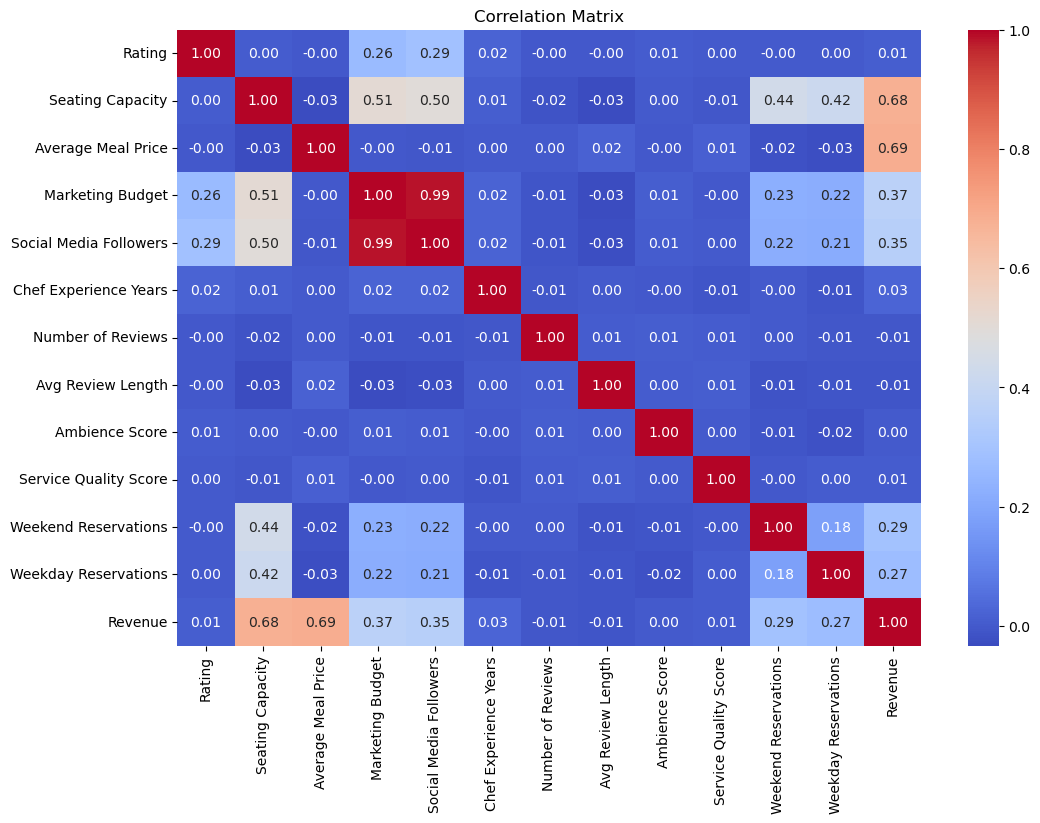

In [ ]:


# Calculate the correlation matrix
correlation_matrix = data.drop(columns=['Name', 'Location', 'Cuisine', 'Parking Availability']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Rating

Min: 3.0
Max: 5.0
Mean: 4.008257648183556
Median: 4.0
Standard Deviation: 0.5814736080781615
Correlation between Rating and Revenue: 0.009899208062126987


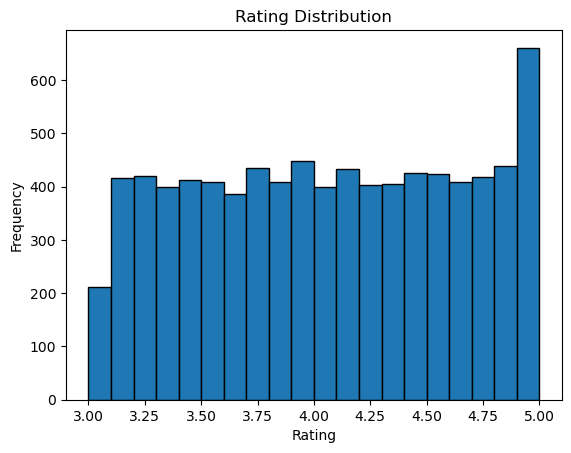

In [19]:
show_data_stats('Rating', bins=20)

I will need to do a couple of transformations to this data.
1. normalize this from [3,5] to [0,1]
2. maybe oversample 3 and 5 values to smooth the impact on the dataset.

Such a minuscule correlation implies that oversampling will not bring me any value.

Also it's possible that if I remove this column from the dataset completely it will not influence the quality of the model.

## Seating capacity

Min: 30
Max: 90
Mean: 60.21283460803059
Median: 60.0
Standard Deviation: 17.399488340801955


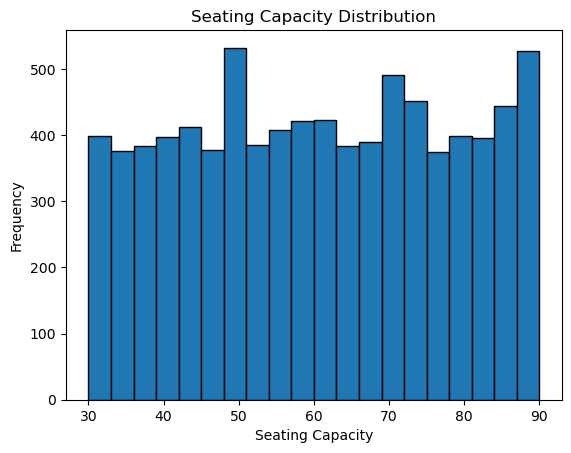

In [14]:
show_data_stats('Seating Capacity');

here we only apply normalization, we have one peak at 50 but it's not important enough

## Average meal price

Min: 25.0
Max: 76.0
Mean: 47.896658699808796
Median: 45.535
Standard Deviation: 14.336766739814099


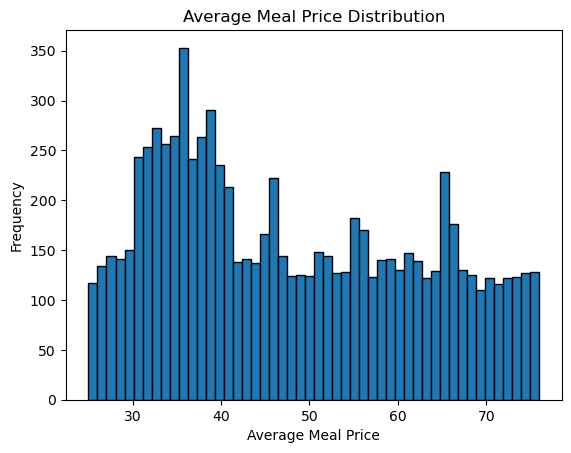

In [16]:
show_data_stats('Average Meal Price', bins=50);

This curve is a bit worrying but I think we can manage with just the normalization of values, too.

## Marketing Budget

In [ ]:
show_data_stats('Marketing Budget');

---

Summarizing, you must first scale (or standardize) separately each input variable
of your data, scale your desired output variables, and use these scaled patterns to train
the neural network. Then, when the training is finished, you can make predictions over
new patterns in three steps: scale the pattern, introduce it into the neural network,
and descale the obtained output from the network.

In [9]:
# TODO

Import out in-house neural network class, at the beginning it will output a lot of internal debugging immediately

In [10]:
from NeuralNet import NeuralNet

In [11]:
layers = [4, 9, 5, 1]
nn = NeuralNet(layers)

print("L = ", nn.L, end="\n")
print("n = ", nn.n, end="\n")

print("xi = ", nn.xi, end="\n")
print("xi[0] = ", nn.xi[0], end="\n")
print("xi[1] = ", nn.xi[0], end="\n")

print("wh = ", nn.w, end="\n")
print("wh[1] = ", nn.w[1], end="\n")

TypeError: NeuralNet.__init__() takes 1 positional argument but 2 were given

Solve the assignment 1 below

In [ ]:
# TODO

In [ ]:
    # Optional: Plot the evolution of the training and validation errors
    # Feed−forward all test patterns
    # Descale the predictions of test patterns, and evaluate them
    # test_predictions = self.predict(x)